In [34]:
%matplotlib widget

import io
import configparser
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

from tathu.io import spatialite, pgis
from tathu import visualizer
from tathu.utils import extractPeriods, file2timestamp, array2raster, getGeoT, geo2grid

def bytea2nparray(bytea):
    """Converts Numpy Array from Postgres to python."""
    bdata = io.BytesIO(bytea)
    bdata.seek(0)
    return np.load(bdata)

### 25 km

In [35]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"
clusters_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/clusters_aero_systems_25km.csv"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


In [36]:
# Get clusters data
clusters_25 = pd.read_csv(clusters_path).set_index('name').drop(columns=["max area"])
clusters_25['count'] = clusters_25.groupby('clust')['clust'].transform('count')
clusters_25['clust_c'] = 'Cluster ' + clusters_25['clust'].astype(str) + ' - ' + clusters_25['count'].astype(str) + ' cases'

In [37]:
clusters_25.describe()

,clust,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,sub-50nm aerosols,count
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,2.525000,55.031188,13.262500,12.006250,7.443750,0.298251,0.182751,0.184973,52.768750,2484.419566,-26.234313,80.813123,-2.262630,4.262677,2942.243079,664.508602,40.050000
std,1.132427,3.397995,1.895003,2.359237,2.284063,0.062385,0.077806,0.014480,131.977043,1520.790916,35.454204,9.499430,3.150483,0.427534,3152.813805,720.306835,1.417767
min,1.000000,46.920000,7.000000,6.000000,4.000000,0.141964,0.000000,0.141964,0.000000,-30.380970,-155.760930,51.800180,-9.761905,2.458601,115.719710,13.515922,38.000000
25%,1.750000,52.787500,12.000000,10.000000,6.000000,0.250988,0.119154,0.175360,1.000000,1296.508625,-49.139154,74.377500,-4.405239,4.122192,1029.937825,224.181533,40.000000
50%,3.000000,54.855000,14.000000,12.000000,7.000000,0.295563,0.185637,0.184447,9.000000,2452.099600,-4.376690,79.613070,-1.963304,4.361352,1875.659450,422.829750,40.000000
75%,4.000000,57.005000,15.000000,14.000000,9.000000,0.351232,0.243551,0.196318,34.500000,3823.203400,0.000000,87.492303,-0.572857,4.505810,3623.785450,857.646210,42.000000
max,4.000000,63.870000,15.000000,15.000000,15.000000,0.463247,0.355478,0.226116,922.000000,6351.676000,0.000000,99.871080,9.961557,5.211758,19710.900000,6224.416500,42.000000


In [38]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init25 FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]

# -- ALl clusters params
query = (
    "SELECT name, echotop_0, echotop_20, echotop_40, vil_kgm2, vii_kgm2, viwl_kgm2, gld_strmin FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
names_all = [q[0] for q in db.query(query)]
echotop0 = [q[1] for q in db.query(query)]
echotop20 = [q[2] for q in db.query(query)]
echotop40 = [q[3] for q in db.query(query)]
vil = [bytea2nparray(q[4]).max() / 10000 for q in db.query(query)]
vii = [bytea2nparray(q[5]).max() / 10000 for q in db.query(query)]
viwl = [bytea2nparray(q[6]).max() / 10000 for q in db.query(query)]
gld_strmin = [q[7] for q in db.query(query)]

In [39]:
systems = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
    }
).set_index('name')
systems['hour_init'] = systems.date_init.dt.hour
systems['month_init'] = systems.date_init.dt.month

systems = systems.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area'])
systems.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
]

In [40]:
systems_all = pd.DataFrame(
    {
        'name': names_all,
        'echotop0': echotop0,
        'echotop20': echotop20,
        'echotop40': echotop40,
        'vil': vil,
        'vii': vii,
        'viwl': viwl,
        'gld_strmin': gld_strmin,
    }
).set_index('name')

systems_all['echotop0'] = np.where(systems_all['echotop0'] < 2, np.nan, systems_all['echotop0'])
systems_all['echotop20'] = np.where(systems_all['echotop20'] < 2, np.nan, systems_all['echotop20'])
systems_all['echotop40'] = np.where(systems_all['echotop40'] < 2, np.nan, systems_all['echotop40'])

In [41]:
clusters_25_all = systems_all[systems_all.index.isin(clusters_25.index)]
clusters_25_all.merge(clusters_25[['clust']], left_index=True, right_index=True).to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/clusters_all_25km.csv')

In [42]:
clusters_25 = clusters_25.join(systems.loc[clusters_25.index.values], how="left")
clusters_25 = clusters_25[
    [
        'clust_c',
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIL', 
        'max VII', 
        'max VIWL',
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'sub-50nm aerosols', 
    ]
]

/home/camilacl/miniconda3/envs/env-tathu/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


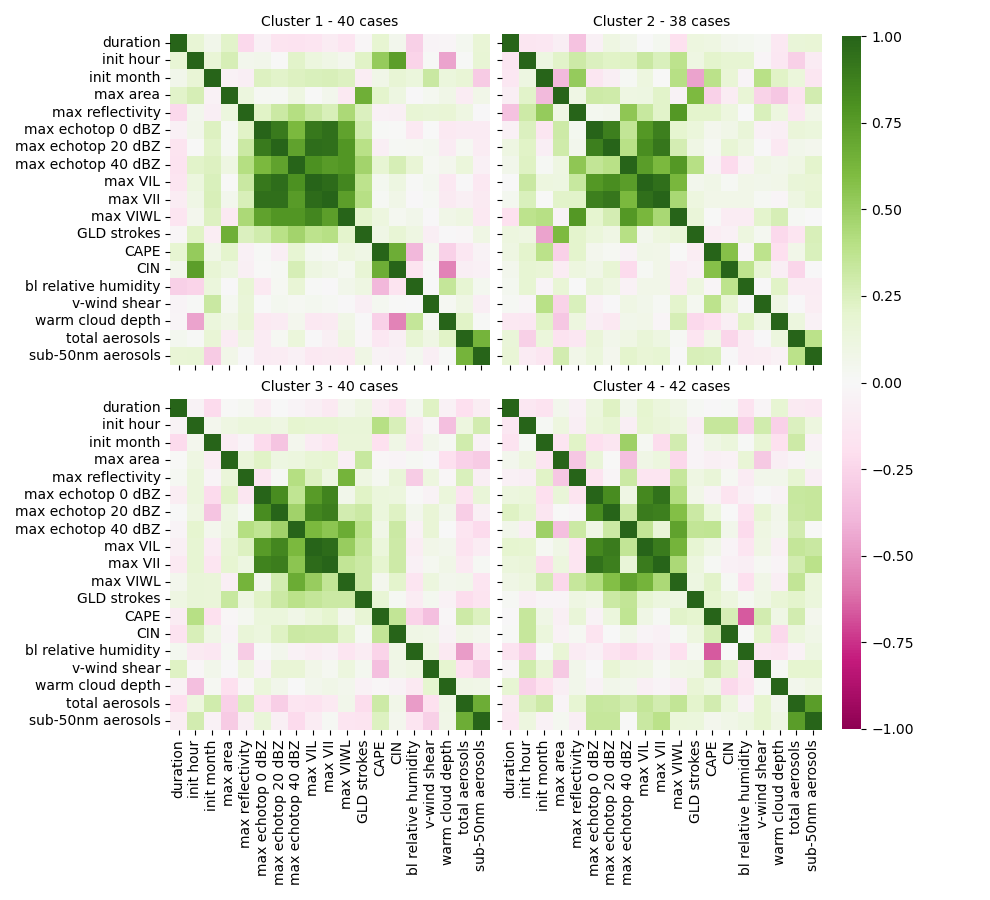

In [44]:
import seaborn as sns

def facet_heatmap(data, **kws):
    g = sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='PiYG', **kws)

g = sns.FacetGrid(clusters_25, col='clust_c', col_wrap=2, col_order=['Cluster 1 - 40 cases', 'Cluster 2 - 38 cases', 'Cluster 3 - 40 cases', 'Cluster 4 - 42 cases'], margin_titles=True, height=4.5, aspect=1.1)

cbar_ax = g.fig.add_axes([.85, .19, .02, .77])  # <-- Create a colorbar axes

g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax)
g.set_titles("{col_name}")
g.fig.subplots_adjust(right=.83)

plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_clust_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

### 10 km

In [45]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"
clusters_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/clusters_aero_systems_10km.csv"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


In [46]:
# Get clusters data
clusters_10 = pd.read_csv(clusters_path).set_index('name').drop(columns=["max area"])
clusters_10['count'] = clusters_10.groupby('clust')['clust'].transform('count')
clusters_10['clust_c'] = 'Cluster ' + clusters_10['clust'].astype(str) + ' - ' + clusters_10['count'].astype(str) + ' cases'

In [47]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init10 FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]

# -- ALl clusters params
query = (
    "SELECT name, echotop_0, echotop_20, echotop_40, vil_kgm2, vii_kgm2, viwl_kgm2, gld_strmin FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
names_all = [q[0] for q in db.query(query)]
echotop0 = [q[1] for q in db.query(query)]
echotop20 = [q[2] for q in db.query(query)]
echotop40 = [q[3] for q in db.query(query)]
vil = [bytea2nparray(q[4]).max() / 10000 for q in db.query(query)]
vii = [bytea2nparray(q[5]).max() / 10000 for q in db.query(query)]
viwl = [bytea2nparray(q[6]).max() / 10000 for q in db.query(query)]
gld_strmin = [q[7] for q in db.query(query)]

In [48]:
systems = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
    }
).set_index('name')
systems['hour_init'] = systems.date_init.dt.hour
systems['month_init'] = systems.date_init.dt.month

systems = systems.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area'])
systems.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
]

In [49]:
systems_all = pd.DataFrame(
    {
        'name': names_all,
        'echotop0': echotop0,
        'echotop20': echotop20,
        'echotop40': echotop40,
        'vil': vil,
        'vii': vii,
        'viwl': viwl,
        'gld_strmin': gld_strmin,
    }
).set_index('name')

systems_all['echotop0'] = np.where(systems_all['echotop0'] < 2, np.nan, systems_all['echotop0'])
systems_all['echotop20'] = np.where(systems_all['echotop20'] < 2, np.nan, systems_all['echotop20'])
systems_all['echotop40'] = np.where(systems_all['echotop40'] < 2, np.nan, systems_all['echotop40'])

In [50]:
clusters_10_all = systems_all[systems_all.index.isin(clusters_10.index)]
clusters_10_all.merge(clusters_10[['clust']], left_index=True, right_index=True).to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/clusters_all_10km.csv')

In [51]:
clusters_10_all

,echotop0,echotop20,echotop40,vil,vii,viwl,gld_strmin
name,,,,,,,
08405c22-c76b-49ab-954d-5fdec09c22c7,11.0,9.0,6.0,0.2167,0.0848,0.2167,NaN
08405c22-c76b-49ab-954d-5fdec09c22c7,13.0,11.0,8.0,0.3035,0.1714,0.3035,0.000000
115452ac-eb5b-4ee4-82ad-d92b7bb0d16b,9.0,9.0,NaN,0.1907,0.0340,0.1907,NaN
115452ac-eb5b-4ee4-82ad-d92b7bb0d16b,11.0,9.0,5.0,0.2423,0.0971,0.2423,0.000000
115452ac-eb5b-4ee4-82ad-d92b7bb0d16b,13.0,13.0,7.0,0.2902,0.1783,0.2902,0.083333
...,...,...,...,...,...,...,...
ff9ed1c8-a825-4e30-9f16-fbee44325b4b,12.0,12.0,5.0,0.2619,0.1407,0.2619,0.083333
ff9ed1c8-a825-4e30-9f16-fbee44325b4b,11.0,11.0,6.0,0.2478,0.1071,0.2478,0.000000
ff9ed1c8-a825-4e30-9f16-fbee44325b4b,13.0,11.0,6.0,0.3028,0.1806,0.3028,0.000000


In [52]:
clusters_10 = clusters_10.join(systems.loc[clusters_10.index.values], how="left")
clusters_10 = clusters_10[
    [
        'clust_c',
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIL', 
        'max VII', 
        'max VIWL',
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'sub-50nm aerosols', 
    ]
]

/home/camilacl/miniconda3/envs/env-tathu/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


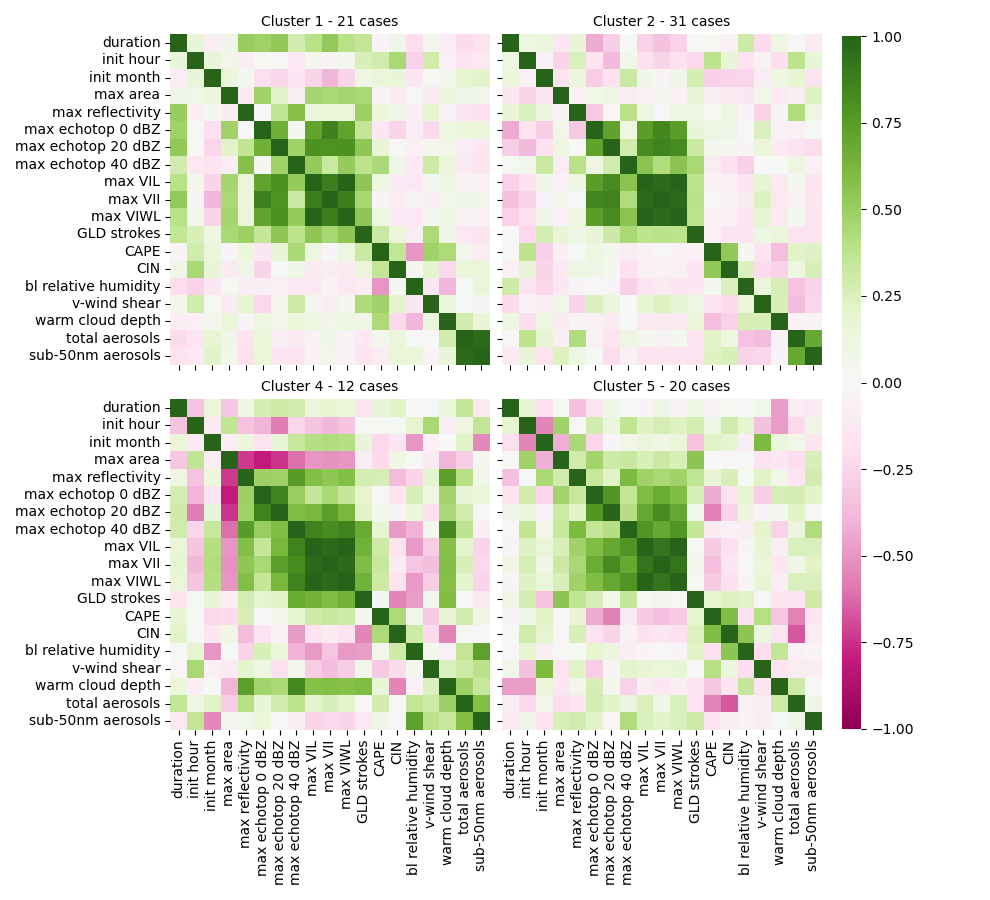

In [53]:
import seaborn as sns

def facet_heatmap(data, **kws):
    g = sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='PiYG', **kws)

g = sns.FacetGrid(clusters_10, col='clust_c', col_wrap=2, col_order=['Cluster 1 - 21 cases', 'Cluster 2 - 31 cases', 'Cluster 4 - 12 cases', 'Cluster 5 - 20 cases'], margin_titles=True, height=4.5, aspect=1.1)

cbar_ax = g.fig.add_axes([.85, .19, .02, .77])  # <-- Create a colorbar axes

g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax)
g.set_titles("{col_name}")
g.fig.subplots_adjust(right=.83)

plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_clust_init10.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)